In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, recall_score, f1_score, precision_score

In [28]:
# загрузка данных
df = pd.read_csv('Datasets/bank-additional-full.csv', delimiter=';')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [29]:
# выбор наиболее значимых признаков
X = df[['age', 'cons.price.idx', 'job', 'education', 'default', 'housing', 'loan']]
y = df['y']

In [30]:
# разделение на непрерывные и категориальные признаки
num_feat = ['age', 'cons.price.idx']
cat_feat = ['job', 'education', 'default', 'housing', 'loan']

In [31]:
# разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# кодировщик для категориальных фич
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# шкалировщик для непрерывных фич
scaler = StandardScaler()

# объединение шкалировщика и кодировщика
prepr = ColumnTransformer([('encoder', encoder, cat_feat), ('scaler', scaler, num_feat)], sparse_threshold=0)

# применение пайплайна на тренировочном наборе
transformed_train = prepr.fit_transform(X_train)

In [32]:
# балансировка классов с помощью SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)

# результирующие данные
X_res, y_res = smote.fit_resample(transformed_train, y_train)

In [33]:
# импорт модели
logit = LogisticRegression()

# пространство значений гиперпараметра регуляризации C
params = [{'C': [0.1, 0.5, 1., 1.5, 2., 2.5]}]

# подбор значений гиперпараметра с помощью метрики balanced_accuracy
clf = GridSearchCV(logit, params, scoring='balanced_accuracy')
clf.fit(X_res, y_res)

# оптимальный параметр C
best_param = clf.best_params_['C']

# построение пайплайна
pipe = Pipeline([('prepr', prepr), ('clf', clf)])

# применение препроцессора и классификатора на тестовом наборе
pred = pipe.predict(X_test) # предсказанные классы
decision = pipe.decision_function(X_test) # вещественные значения, вычисленные линейной функцией

In [34]:
# вычисление значений метрик
balanced = balanced_accuracy_score(y_test, pred)
roc = roc_auc_score(y_test, decision)
precision = precision_score(y_test, pred, pos_label='yes')
recall = recall_score(y_test, pred, pos_label='yes')
f1 = f1_score(y_test, pred, pos_label='yes')

# вывод результатов 
index = ['Best C', 'Balanced accuracy', 'AUC', 'Precision', 'Recall', 'F1']
values = [best_param, balanced, roc, precision, recall, f1]
metrics = pd.Series(np.round(values, 3), index)

metrics

Best C               2.000
Balanced accuracy    0.625
AUC                  0.685
Precision            0.172
Recall               0.638
F1                   0.271
dtype: float64

## Визуализация AUC-ROC 

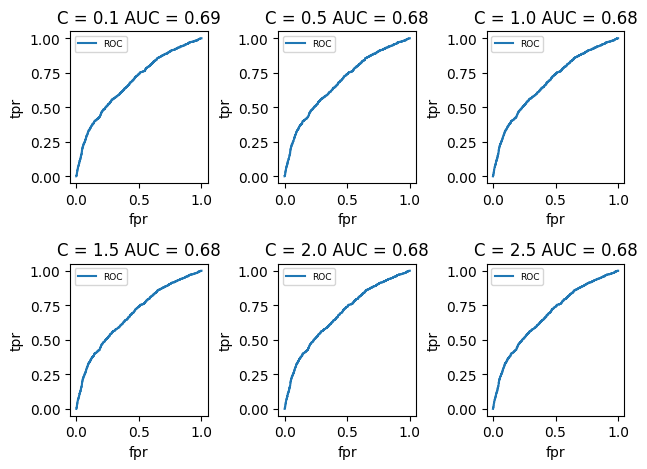

In [19]:
fig, axs = plt.subplots(2, 3)
coef = clf.get_params()['param_grid'][0]['C']
i, j, c = [0, 0, 0]
while i <= 1:
    while j <= 2:
        logit.set_params(C=coef[c])
        logit.fit(X_res, y_res)
        trans_test = prepr.transform(X_test)
        decision = logit.decision_function(trans_test)
        fpr, tpr, thresholds = roc_curve(y_test, decision, pos_label='yes')
        auc = roc_auc_score(y_test, decision)
        axs[i, j].plot(fpr, tpr, label='ROC')
        axs[i, j].set_title('C = {} AUC = {:.2f}'.format(coef[c], auc))
        axs[i, j].set_xlabel('fpr')
        axs[i, j].set_ylabel('tpr')
        axs[i, j].legend(fontsize=6.5)
        j += 1
        c += 1
    j = 0
    i += 1
fig.tight_layout()
plt.show()